In [54]:
using LoopVectorization, StaticArrays, BenchmarkTools

┌ Info: Precompiling BenchmarkTools [6e4b80f9-dd63-53aa-95a3-0cdb28fa8baf]
└ @ Base loading.jl:1278


In [2]:
using Revise, BeamPropagation, Distributions, StatsBase, StaticArrays, PhysicalConstants.CODATA2018, Plots, BenchmarkTools

In [197]:
function avx_test(a, b, c)
    @turbo for i in 1:size(a,1)
        c[i] += sqrt(sum((a[i] - b[i]).^2))
    end
    return nothing
end

LoadError: LoadError: Don't know how to handle expression.
if 1 > 0
    #= In[197]:4 =#
    c[i] = add_fast(sqrt(sum(sub_fast(a[i], b[i]) .^ 2)), c[i])
end
in expression starting at In[197]:2

In [196]:
n = 100
a = Array{SVector{3, Float64}}(undef, n)
b = deepcopy(a)
c = rand(Float64, n)
;

In [194]:
@btime avx_test($a, $b, $c)

  217.829 ns (0 allocations: 0 bytes)


In [3]:
const h = PlanckConstant.val
const ħ = h / 2π
const λ = @with_unit 626 "nm"
const k = 2π / λ
const m = @with_unit 57 "u"
const Δv = ħ * k / m
;

In [4]:
vz_μ = @with_unit 125 "m/s"
vz_σ = @with_unit 25 "m/s"
vxy_μ = @with_unit 0 "m/s"
vxy_σ = @with_unit 25 "m/s"
exit_radius = @with_unit 4 "mm"
;

In [5]:
const r = (
    Normal(0, exit_radius/2), 
    Normal(0, exit_radius/2), 
    Normal(0, 0)
)
const v = (
    Normal(vxy_μ, vxy_σ), 
    Normal(vxy_μ, vxy_σ), 
    Normal(vz_μ, vz_σ)
)
const a = (
    Normal(0, 0),
    Normal(0, 0), 
    Normal(0, 0)
)
;

In [6]:
VBRs = Weights([
    0.9457,     # to 000
    0.0447,     # 100
    3.9e-3,     # 0200
    2.7e-3,     # 200
    9.9e-4,     # 0220
    7.5e-4,     # 0110
    3.8e-4,     # 0110, N=2
    3.9e-4,     # 1200
    1.5e-4,     # 300
    1.3e-4,     # 1220
    0.7e-4,     # 110 (only N=1, assuming roughly 2/3 to 1/3 rotational branching)
    0.4e-4,     # 110, N=2
    5.7e-5,     # 220
    4.3e-5      # other states
])

longitudinal = [
    true,   # to 000
    true,   # 100
    true,   # 0200
    true,   # 200
    true,   # 0220
    true,   # 0110
    true,   # 0110, N=2
    true,   # 1200
    true,   # 300
    false,   # 1220
    false,   # 110
    false,  # 110, N=2
    false,  # 220
    false   # other states
]

transverse = [
    false,  # to 000
    false,   # 100
    false,  # 0200
    false,  # 200
    false,  # 0220
    false,  # 0110
    false,  # 0110, N=2
    false,  # 1200
    false,   # 300
    true,   # 1220
    true,   # 110
    false,  # 110, N=2
    false,  # 220
    false   # other states
]

λs = 1e-9 .* [
    626,
    574,
    629,
    650,
    630,
    567,
    623,
    653,
    595,
    646,
    566,
    600,
    600,
    600
]

;

In [7]:
struct Sideband
    lower::Float64
    upper::Float64
end

std_sideband = Sideband(0, 250)
sidebands = repeat([std_sideband], length(VBRs))
;

In [8]:
@inline function transverse_on(z)
    if 0.15 < z < 0.20
        return true
    elseif 0.45 < z < 0.50
        return true
    elseif 0.56 < z < 0.61
        return true
    end
    return false
end

@inline function random_unit3Dvector()
    θ = rand(Uniform(0, 2π))
    z = rand(Uniform(-1, 1))
    return @SVector [sqrt(1-z^2)*cos(θ), sqrt(1-z^2)*sin(θ), z]
end
;

In [9]:
const detect_rad  = @with_unit 0.5 "cm"
const detect_zloc = @with_unit 71 "cm"
const detect_zlen = @with_unit 0.5 "cm"
const dead_rad = @with_unit 1.0 "cm"
const dead_len = detect_zloc + detect_zlen
;

In [10]:
@inline function simple_prop(r, v)
    dist_detect = detect_zloc - r[3]
    x_final = r[1] + v[1] * dist_detect / v[3]
    y_final = r[2] + v[2] * dist_detect / v[3]
    return sqrt(x_final^2 + y_final^2)
end

@inline discard(r, v) = (simple_prop(r, v) > dead_rad) || (r[3] > dead_len)
@inline is_detectable(r) = sqrt(r[1]^2 + r[2]^2) < detect_rad && (detect_zloc + detect_zlen > r[3] > detect_zloc)
;

In [11]:
Γ = 2π * 6.4e6
Ng = 12
Ne = 4
s_ = 0.405
Γeff = Γ * 2Ne / (Ng + Ne)
seff = (s_/2) * (Ng + Ne) / 2Ng
Δv_to_Δf(Δv, λ) = (Δv / λ)
Δf_to_Δv(Δf, λ) = (λ * Δf)
sideband_spacing = @with_unit 4.5 "MHz"

@inline function Rsc(λ, Γ, s, v, sideband_spacing, sideband)
    R = 0
    sideband_spacing_v = Δf_to_Δv(sideband_spacing, λ)
    spectrum = sideband.lower:sideband_spacing_v:sideband.upper # This is in terms of velocity
    s /= length(spectrum)
    for v_s in spectrum
        Δ = Δv_to_Δf(v_s - v, λ)
        R += (s/2) * Γ / (1 + 4(Δ/Γ)^2 + s)
    end
    return R
end

vs = 0:1:300
Rscs = zeros(Float64, length(vs), length(VBRs))
for (i,v) in enumerate(vs)
    for state in 1:size(VBRs,1)
        Rscs[i, state] = Rsc(λs[state], Γ, s_, v, sideband_spacing, sidebands[state])
    end
end

@inline function interpolate_Rsc(Rscs, vz, state)
    if vz < 0
        return 0.0
    end
    v_idx = round(Int64, vz) + 1
    Rsc = Rscs[v_idx, state]
    return Rsc
end
;

In [12]:
# @inline function save(i, r, v, a, state, s)
#     s.vzs[i] = v[3]
#     s.detectable[i] = simple_prop(r, v) < detect_rad
#     return nothing
# end

# @inline function f(i, r, v, a, state, dt, p, s)
#     state′ = state
#     v′ = v
#     s.detectable[i] |= is_detectable(r)
    
#     if p.longitudinal[state] || (p.transverse[state] && transverse_on(r[3])) 
#         p_scatter = min(1, interpolate_Rsc(p.Rscs, v[3], state) / p.scattering_rate)
#         if rand() < p_scatter
#             state′ = sample(1:14, p.VBRs)
#             v′ = @SVector [v[1], v[2], v[3] - Δv]
#             v′ += Δv .* random_unit3Dvector()
#             s.photons[i] += 1
#         end
#     end
    
#     s.vzs[i] = v′[3]
#     s.states[i] = state′
#     return (state′, v′, a)
# end
;

In [54]:
@inline function f(particle, dt, p, s)
    return (particle.v, particle.a)
end

@inline function save(particles, p, s)
    for i in 1:size(particles, 1)
        s.zs[particles[i].idx] = particles[i].r[3]
    end
    return nothing
end
;

In [70]:
n = Int64(1e3)
scattering_rate = @with_unit 1.2 "MHz"
delete_every    = 15
dt              = 1 / scattering_rate
max_steps       = Int64(3.5e4)
;

In [71]:
vzs           = zeros(Float64, n)
photons       = zeros(Int64, n)
detectable    = zeros(Bool, n)
states        = ones(Int64, n)

v_cutoff = @with_unit 50 "m/s"
p  = @params (VBRs, transverse, longitudinal, v_cutoff, sidebands, Rscs, scattering_rate)
# s = @params (vzs, photons, detectable, states)
# sf = deepcopy(s0)

# @time s0, sf = propagate!(n, dt, r, v, a, f, save, discard, delete_every, max_steps, p, s0, sf)
# bright = [longitudinal[final_state] || transverse[final_state] for final_state in sf.states]
# ;

In [127]:
using StructArrays
particles = StructArray{Particle}(undef, n)
abstol = 1e-5

zs = zeros(Float64, n)

s = @params (zs,)

@time propagate_particles!(r, v, a, particles, f, save, discard, delete_every, max_steps, p, s, dt, abstol)
;

  0.007119 seconds (105.04 k allocations: 11.219 MiB)


In [128]:
maximum(s.zs)

0.0

In [19]:
sum(37.5 .< sf.vzs[sf.detectable .& bright] .< 42.5) * 2e7 / n

LoadError: UndefVarError: sf not defined

In [17]:
barhist(s0.vzs[s0.detectable], bins=0:10:225, alpha=0.5, xlim=[0,225], label="Unperturbed")
barhist!(sf.vzs[sf.detectable], bins=0:10:225, alpha=0.5, label="Slowed")
barhist!(sf.vzs[sf.detectable .& bright], bins=0:10:225, alpha=0.3, label="Slowed and detected")
xlabel!("Velocity (m/s)")
ylabel!("Molecule count")

LoadError: UndefVarError: s0 not defined

In [342]:
v_class = 0 .< sₜ.vzs .< 100
histogram2d(sₜ.vzs[sₜ.detectable .& bright.& v_class], s₀.vzs[sₜ.detectable .& bright .& v_class], bins=30)
ylabel!("Initial velocity (m/s)")
xlabel!("Slowed velocity (m/s)")

LoadError: ArgumentError: collection must be non-empty

In [258]:
delete_idxs = 1:100000;

In [260]:
@btime StructArrays.foreachfield(v -> deleteat!(v, $delete_idxs), particles_) setup=(particles_=deepcopy(particles_soa)) evals=1
;

  1.299 μs (0 allocations: 0 bytes)


In [26]:
iters = 1

v_cutoffs = 55:2.0:75
data = zeros(iters, size(v_cutoffs, 1))

for i in 1:iters
    for (j, v_cutoff) in enumerate(v_cutoffs)

        vzs           = zeros(Float64, n)
        photons       = zeros(Int64, n)
        detectable    = zeros(Bool, n)
        states        = ones(Int64, n)
        s = @params (vzs, photons, detectable, states)
        
        p = @params (VBRs, transverse, addressed, v_cutoff)

        @time s₀, sₜ = propagate!(n, r, v, a, f, save, discard, delete_every, dt, max_steps, p, s)

        bright = [addressed[final_state] for final_state in sₜ.states]
        perc_under_10ms = sum(abs.(sₜ.vzs[sₜ.detectable .& bright]) .< 10) / sum(s₀.detectable)
        data[i,j] = perc_under_10ms
    end
end

LoadError: UndefVarError: addressed not defined

In [256]:
@time StructArrays.foreachfield(v -> deleteat!(v, delete_idxs), particles_soa)

  0.009094 seconds (9.25 k allocations: 533.613 KiB)


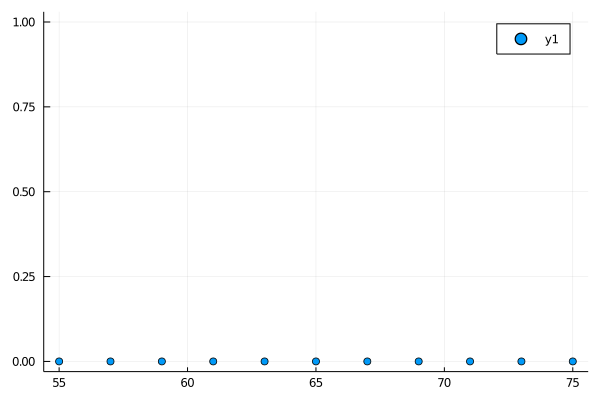

In [27]:
scatter(v_cutoffs, mean(data, dims=1)')

In [6034]:
# This assumes that the z-axis is discretized into 7100 elements across 71 cm (so each element covers 0.1 mm)
@inline function interpolate_forceprofile(forceprofile, r, v)
    z = r[3]
    force_idx = round(Int64, z * 1e4) + 1
    force = forceprofile[force_idx]
    return force
end
forceprofile = collect(0:0.0001:0.71)
r_ = @SVector [0.0, 0.0, 0.4]
v_ = @SVector [0.0, 0.0, 0.0]
@btime interpolate_forceprofile($forceprofile, $r_, $v_)

  4.799 ns (0 allocations: 0 bytes)


0.4